In [1]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.8/883.8 kB 13.4 MB/s eta 0:00:00


In [2]:
##Importing Libraries
import shutil
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import math

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
Dustbin_Detect=YOLO('/content/drive/MyDrive/Waste_segmentation/Dustbin_Segmentation_Weights/segment/train/weights/last.pt')
Waste_Detect=YOLO('/content/drive/MyDrive/Waste_segmentation/Waste_Segmentation_Weights/segment/train/weights/last.pt')
Angle_Classify=YOLO('/content/drive/MyDrive/Waste_segmentation/Dustbin_Angle_Classification/classify/train/weights/last.pt')

In [4]:
shutil.copytree('/content/drive/MyDrive/Waste_segmentation/Test_Dustbin_Segmentation','/content/Test_Dustbin_Segmentation')

'/content/Test_Dustbin_Segmentation'

In [5]:
def from_top(img,Dustbin_Detect,Waste_Detect):
  dustbin_capture=[]
  waste_capture=[]
  dustbin_result=Dustbin_Detect(img)
  all_boxes = dustbin_result[0].boxes.xyxy.cpu().numpy().astype(int)
  if len(all_boxes) > 0:
    for box in all_boxes:
      x1, y1, x2, y2 = box
      dust_masks = dustbin_result[0].masks.data.cpu().numpy()
      dustbin_count = (dust_masks[0] != 0).sum()
      resized_mask = cv2.resize(dust_masks[0], (img.shape[1], img.shape[0]))

      for i in range(resized_mask.shape[0]):
        for j in range(resized_mask.shape[1]):
          if (resized_mask[i][j]!=0).any():
            dustbin_capture.append((i,j))

      dustbin=img[y1:y2,x1:x2]
      cropped_dustbin_mask=dust_masks[0][y1:y2,x1:x2]
      waste_result=Waste_Detect(dustbin)

      waste_boxes = waste_result[0].boxes.xyxy.cpu().numpy().astype(int)
      if len(waste_boxes) > 0:
        masks = waste_result[0].masks.data.cpu().numpy()
        resized_mask = cv2.resize(masks[0], (dustbin.shape[1], dustbin.shape[0]))
        for i in range(resized_mask.shape[0]):
          for j in range(resized_mask.shape[1]):
            if (resized_mask[i][j]!=0).any():
              waste_capture.append((y1+i,x1+j))

        waste_count= (resized_mask != 0).sum()
      else:
        waste_count=0

      result = np.logical_and(cropped_dustbin_mask != 0, resized_mask == 0)
      count = np.sum(result)
      num=math.sqrt(waste_count / math.pi)/math.sqrt(dustbin_count / math.pi)

      ratio=waste_count/dustbin_count
      if(ratio>0.5):
        num=1/num
      if(ratio<=0.3):
        ratio=ratio*0.6
      elif(ratio>0.3 and ratio<=0.5):
        ratio=ratio*0.7
      elif(ratio>0.5 and ratio<=0.6):
        ratio=ratio*1.5
      elif(ratio>0.6 and ratio<=0.8):
        ratio=ratio*1.1
      else:
        ratio=0.9
      final=cv2.putText(img,  f"{ratio*100:.2f}"+"%", (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
      img=final
  else:
    print("No dustbin detected in the image.")
    final=cv2.putText(img,  f"{ratio*100:.2f}"+"%", (0,0), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    img=final

  for (i,j) in dustbin_capture:
    img[i][j]=[255,0,0]
  for (i,j) in waste_capture:
    img[i][j]= [0,0,255]

  return img


In [6]:
def from_side(img,Dustbin_Detect,Waste_Detect):
  dustbin_capture=[]
  waste_capture=[]
  dustbin_result=Dustbin_Detect(img)
  all_boxes = dustbin_result[0].boxes.xyxy.cpu().numpy().astype(int)
  if len(all_boxes) > 0:
    for box in all_boxes:
      x1, y1, x2, y2 = box
      dust_masks = dustbin_result[0].masks.data.cpu().numpy()
      dustbin_count = (dust_masks[0] != 0).sum()
      resized_mask = cv2.resize(dust_masks[0], (img.shape[1], img.shape[0]))

      for i in range(resized_mask.shape[0]):
        for j in range(resized_mask.shape[1]):
          if (resized_mask[i][j]!=0).any():
            dustbin_capture.append((i,j))
      height=int(1.5*(y2-y1))
      dustbin_end=y2+height

      dustbin_volume=dustbin_count*height
      dustbin=img[y1:y2,x1:x2]
      cropped_dustbin_mask=dust_masks[0][y1:y2,x1:x2]
      waste_result=Waste_Detect(dustbin)

      waste_boxes = waste_result[0].boxes.xyxy.cpu().numpy().astype(int)
      if len(waste_boxes) > 0:
        X1, Y1, X2, Y2 = waste_boxes[0]

        masks = waste_result[0].masks.data.cpu().numpy()
        resized_mask = cv2.resize(masks[0], (dustbin.shape[1], dustbin.shape[0]))
        waste_count= (resized_mask != 0).sum()
        for i in range(resized_mask.shape[0]):
          for j in range(resized_mask.shape[1]):
            if (resized_mask[i][j]!=0).any():
              waste_capture.append((y1+i,x1+j))
        waste_volume=(dustbin_count*(dustbin_end-(y2+y2-Y2-y1)))+waste_count
        ratio=waste_volume/dustbin_volume
      else:
        waste_volume=0
        ratio=0
      final=cv2.putText(img,  f"{ratio*100:.2f}"+"%", (x1,y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
      cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
      img=final
  else:
    print("No dustbin detected in the image.")
    ratio=-1
    final=cv2.putText(img, f"{ratio*100:.2f}"+"%", (0,0), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)
    img=final

  for (i,j) in dustbin_capture:
    img[i][j]=[255,0,0]
  for (i,j) in waste_capture:
    img[i][j]=[0,0,255]

  return img


0: 224x224 Top 0.74, Side 0.26, 189.6ms
Speed: 60.0ms preprocess, 189.6ms inference, 0.2ms postprocess per image at shape (1, 3, 224, 224)

0: 480x640 1 Dustbin, 541.9ms
Speed: 10.8ms preprocess, 541.9ms inference, 27.7ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 Waste, 406.5ms
Speed: 6.1ms preprocess, 406.5ms inference, 8.0ms postprocess per image at shape (1, 3, 480, 640)


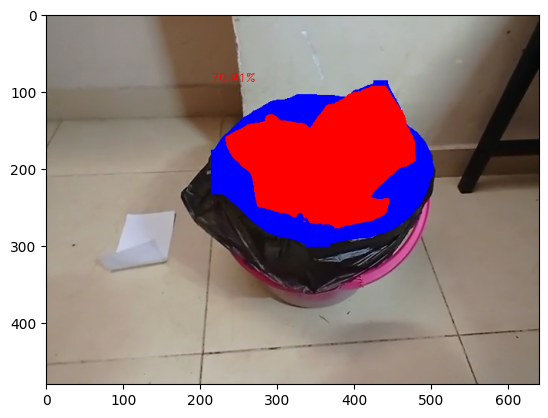

In [ ]:
img=cv2.imread('/content/Test_Dustbin_Segmentation/1070.png')
# img=cv2.imread('/content/5.png')
result=Angle_Classify(img)
if result[0].names[int(result[0].probs.top1)]=="Side":
   ratio=dustbin_capture=from_side(img,Dustbin_Detect,Waste_Detect)
else:
  ratio=from_top(img,Dustbin_Detect,Waste_Detect)

# final=cv2.putText(img, ratio, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
plt.imshow(ratio[:,:,::-1])



In [9]:
# prompt: store the imagearray in images list and result imagearray  in Prediction list for all images in '/content/Test_Dustbin_Segmentation' and also try and except


images = []
predictions = []

image_dir = '/content/Test_Dustbin_Segmentation'
for filename in os.listdir(image_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Adjust extensions as needed
        img_path = os.path.join(image_dir, filename)
        try:
            status=0
            img = cv2.imread(img_path)
            if img is not None:
                images.append(img)
                status=1  # Store the original image
                result = Angle_Classify(img)
                if result[0].names[int(result[0].probs.top1)]=="Side":
                    prediction = from_side(img.copy(), Dustbin_Detect, Waste_Detect) #Operate on a copy to avoid modifying the original
                else:
                    prediction = from_top(img.copy(), Dustbin_Detect, Waste_Detect) #Operate on a copy
                predictions.append(prediction)
            else:
                print(f"Could not read image: {img_path}")
        except Exception as e:
          if status==1:
            predictions.append(img)
            print(f"Error processing {img_path}: {e}")



0: 224x224 Top 1.00, Side 0.00, 31.1ms
Speed: 30.0ms preprocess, 31.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 480x640 1 Dustbin, 374.3ms
Speed: 6.4ms preprocess, 374.3ms inference, 7.2ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 Waste, 492.7ms
Speed: 5.5ms preprocess, 492.7ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)

0: 224x224 Side 1.00, Top 0.00, 31.3ms
Speed: 10.1ms preprocess, 31.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 480x640 1 Dustbin, 379.4ms
Speed: 2.7ms preprocess, 379.4ms inference, 17.9ms postprocess per image at shape (1, 3, 480, 640)

0: 544x640 1 Waste, 268.5ms
Speed: 4.2ms preprocess, 268.5ms inference, 4.7ms postprocess per image at shape (1, 3, 544, 640)

0: 224x224 Side 1.00, Top 0.00, 15.3ms
Speed: 7.1ms preprocess, 15.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

0: 480x640 1 Dustbin, 230.9ms
Speed: 2.5ms preprocess, 230.9ms inference,

In [ ]:
# prompt: display all predictions in 1 plot

import matplotlib.pyplot as plt

# Assuming 'predictions' list is populated as in the previous code

plt.figure(figsize=(20, 10 * (len(predictions) + 1) // 2))  # Adjust figure size as needed

for i, prediction in enumerate(predictions):
    plt.subplot((len(predictions) + 1) // 2, 2, i + 1)  # Create subplots
    plt.imshow(prediction[:, :, ::-1])  # Display images with reversed color channels
    plt.title(f"Prediction {i + 1}")
    plt.axis('off')  # Turn off axis labels

plt.tight_layout()
plt.show()